In [74]:
import utils

In [ ]:
%matplotlib notebook

## Bragg peak progression values and error bars from several outputs, computed with different values of the peak width parameter

In [54]:
beamline_transmission = 0.22

In [55]:
from scipy.interpolate import interp1d
transform_on = True

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams['font.size'] = 8.
mpl.rcParams['font.family'] = 'serif'

golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
figWidth = 3.37
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

In [57]:
w_15 = np.array([np.array([ 1.        ,  1.05473332,  1.06578211,  1.1085688 ,  1.08285494,
         1.08639277,  1.17664317]),
 np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 np.array([ 1.        ,  0.94026273,  0.92851886,  0.96696775,  0.93781928,
         0.94920423,  0.95996687])])
w_20 = np.array([np.array([ 1.        ,  1.06777415,  1.11282934,  1.13556469,  1.11867025,
         1.12980238,  1.19486332]),
 np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 np.array([ 1.        ,  0.98015993,  0.9998324,  1.03187026,  0.97397024,
         1.0270189,  1.03754899])])



In [58]:
progressions = [w_15, w_20]
#progressions = [w_20]
mean = np.mean(progressions, axis = 0)
stderr = np.std(progressions, axis = 0)/np.sqrt(len(progressions))
labels = ['111', '200', '222']

In [59]:
fluxes = np.array([ 23080.999908  ,   9472.38824234,   2404.57689574,    447.60799673,
          101.06103334,     58.8079792 ,     30.16713449][::-1]) * beamline_transmission

In [60]:
i0_200_20 = np.array([ 1.        ,  0.87703524,  0.89841387,  0.8849395 ,  0.89060012,
        0.87608614,  0.9418514 ])
i0_200_15 = np.array([ 1.        ,  0.82095889,  0.86219382,  0.82523548,  0.84587632,
        0.85842783,  0.88508954])


In [61]:
i0_200_mean = np.mean([i0_200_20, i0_200_15], axis = 0)
i0_200_stderr = 1.5 * np.std([i0_200_20, i0_200_15], axis = 0)/np.sqrt(len(progressions))

<IPython.core.display.Javascript object>


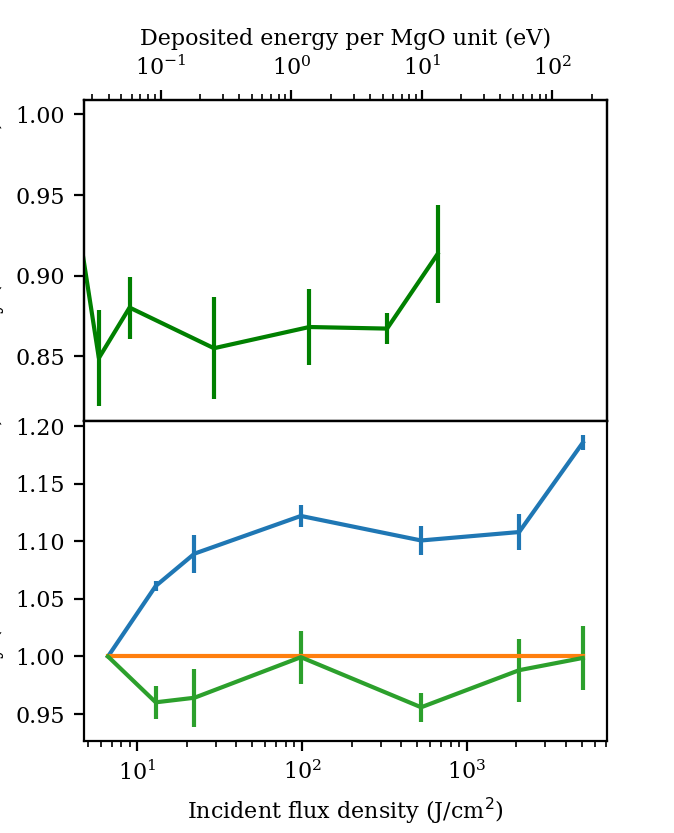

Text(0,0.5,'Intensity (normalized to 200)')

In [62]:
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 2

fig = plt.figure()

x, y = np.arange(10), np.arange(10)
ax1 = fig.add_subplot(2,1,1)
#ax1.plot(x, y)
ax2 = fig.add_subplot(2,1,2,sharex=ax1)

for curve, err, label in zip(mean, stderr, labels):
    ax2.errorbar(fluxes, curve, yerr=err, label = label)
#ax2.plot(x, y)


ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

#ax.text( 
#    .05, 0.5, "Y Label", rotation='vertical',
#    horizontalalignment='center', verticalalignment='center'
#)



fig.subplots_adjust(hspace=0)

#ax1.xaxis.set_label_position('top')
ax2.semilogx()


ax1.set_ylabel('Intensity (I0 normalized)')
#ax1.get_xaxis().set_visible(False)

xscale = .0026
ax1 = ax1.twiny()
ax1.errorbar(fluxes * xscale, i0_200_mean, yerr=i0_200_stderr, label = label, color = 'g')
ax1.set_xlim((xscale * 1e1, xscale * 1e5))
ax1.semilogx()

ax1.set_xlabel('Deposited energy per MgO unit (eV)')
#ax1.text( 
#    .1, 0.1, "(a)"
#)
ax2.set_xlabel('Incident flux density (J/cm$^2$)')

#y2a = ax2.axes.get_yaxis()
#ticks = y2a.get_ticklabels()
#y2a.set_ticklabels([str(t) for t in ticks])

ax2.set_ylabel('Intensity (normalized to 200)')



In [9]:
scfly_ratios

NameError: name 'scfly_ratios' is not defined

In [63]:
gauss = lambda mu, sigma: lambda x: np.exp(-((x - mu)**2) / sigma**2)

x = np.arange(-10, 10, .1)
y = np.arange(-10, 10, .1)
xy = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
r = np.linalg.norm(xy, axis = 1)

g4 = gauss(0, 4.)
hy4, hx = np.histogram(g4(r)[g4(r) > .02], bins = 20)
#plt.plot(hx[:-1], hy4/16)
plt.plot(hx[:-1], hx[:-1] * hy4/16)

from utils import utils
interped = interp1d(hx[:-1], hx[:-1] * hy4)
distribution = utils.extrap1d(interped)

def extend_and_extrap(x, y):
    sorti = np.argsort(x)
    x, y = x[sorti], y[sorti]
    newmax = 2 * max(x)
    start = max(x) * (1. + 1. / len(x))
    newx = np.linspace(start, newmax, len(x))
    interped = interp1d(x, y, fill_value='extrapolate')
    return np.concatenate((x, newx)), np.concatenate((y, interped(newx)))

def response_sampler(x, y):
    x, y = extend_and_extrap(x, y)
    xmin, xmax = interped.x[0], interped.x[-1]
    iresponse = utils.extrap1d(interp1d(x, y))
    def sampled(x0):
        scale = x0 / (xmax / 2.)
        sample_x = x[x <= 2 * x0] / scale
        #sample_y = iresponse(sample_x)
        #sample_y /= np.sum(sample_y)
        window = distribution(sample_x)
        window /= np.sum(window)
        #pdb.set_trace()
        return np.dot(y[x <= 2 * x0], window)
    def sampled_arr(xin):
        return np.array(list(map(sampled, xin)))
    return sampled_arr

def transform(*args):
    x, y = args
    sampler = response_sampler(x, y)
    return x, sampler(x)

In [64]:
if transform_on:
    scfly_intensities, scfly_ratios = transform(*np.genfromtxt('scfly_progression.dat'))
    vasp_intensities, vasp_ratios = transform(*np.genfromtxt('vasp_progression.dat'))
    scfly_vasp_intensities, scfly_vasp_ratios = transform(*np.genfromtxt('scfly_vasp_progression.dat'))
else:
    scfly_intensities, scfly_ratios = np.genfromtxt('scfly_progression.dat')
    vasp_intensities, vasp_ratios = np.genfromtxt('vasp_progression.dat')
    scfly_vasp_intensities, scfly_vasp_ratios = np.genfromtxt('scfly_vasp_progression.dat')
scfly_intensities *= beamline_transmission
vasp_intensities *= beamline_transmission
scfly_vasp_intensities *= beamline_transmission

vasp_ratios = vasp_ratios[vasp_intensities > 10]
vasp_intensities = vasp_intensities[vasp_intensities > 10]

/Users/oliver/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [61]:
scfly_intensities_t, scfly_ratios_t = transform(*np.genfromtxt('scfly_progression.dat'))

In [41]:
plt.plot(scfly_intensities, scfly_ratios)
plt.plot(scfly_intensities_t, scfly_ratios_t)
#plt.plot(*extend_and_extrap(scfly_intensities, scfly_ratios))

In [13]:
si, sr = np.genfromtxt('scfly_progression.dat')

In [14]:
sorti = np.argsort(si)

In [15]:
ss = response_sampler(si[sorti], sr[sorti])

NameError: name 'response_sampler' is not defined

In [86]:
ss([10000])

array([ 1.119791])

In [87]:
ss([5000])

array([ 1.10061034])

<IPython.core.display.Javascript object>


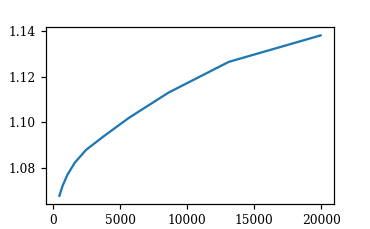

In [88]:
plt.plot(si, ss(si))

<IPython.core.display.Javascript object>


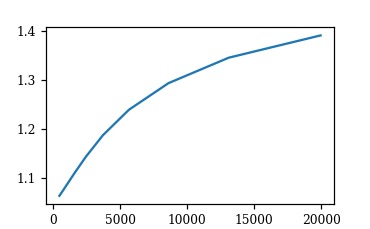

In [34]:
plt.plot(si, sr)

### AFF model, assuming all XFEL energy goes to O 2p ionization, with a 7.8 eV needed per ionized electron

In [65]:
avogadro = 6.022 * 10**23
to_ev = 6.24e18
peratom = lambda I, mu, M, rho: I * M / (mu * rho * avogadro)
to_ev * 2.4e-17

def flux_to_ev(flux):
    return peratom(flux, .015, 40.3, 3.6) * to_ev

def ev_to_flux(ev):
    return ev / (peratom(1., .015, 40.3, 3.6) * to_ev)

bandgap = 7.8

In [66]:
i200 = np.array([1283.76, 1279.2, 1274.64, 1270.08, 1265.54, 1261., 1256.48, 1251.96, \
1247.44, 1242.94, 1238.45, 1233.96, 1229.48, 1225.01, 1220.55, \
1216.09, 1211.64, 1207.21, 1202.78, 1198.35, 1193.94, 1189.53, \
1185.14, 1180.75, 1176.37, 1171.99, 1167.63, 1163.27, 1158.92, \
1154.58, 1150.25, 1145.92, 1141.61, 1137.3, 1133., 1128.71, 1124.43, \
1120.15, 1115.88, 1111.62, 1107.37, 1103.13, 1098.9, 1094.67, \
1090.45, 1086.24, 1082.04, 1077.84, 1073.66, 1069.48, 1065.31, \
1061.15, 1057., 1052.85, 1048.71, 1044.59, 1040.46, 1036.35, 1032.25, \
1028.15, 1024.06, 1019.98, 1015.91, 1011.85, 1007.79, 1003.74, \
999.705, 995.674, 991.651, 987.636, 983.63, 979.631, 975.641, \
971.659, 967.684, 963.718, 959.761, 955.811, 951.869, 947.936, \
944.011, 940.094, 936.185, 932.284, 928.391, 924.507, 920.63, \
916.762, 912.902, 909.05, 905.206, 901.371, 897.543, 893.724, \
889.912, 886.109, 882.314, 878.528, 874.749, 870.978, 867.216, \
863.462, 859.716, 855.978, 852.248, 848.526, 844.813, 841.108, \
837.41, 833.721, 830.04, 826.367, 822.703, 819.046, 815.398, 811.758, \
808.126, 804.502, 800.886, 797.278, 793.679])
i200 /= np.mean(i200)

dat =  np.genfromtxt('MgO_O2p.txt')
x, i111, _, i220 = dat[:4]
x *= beamline_transmission
labels  = ['111', '200', '220']

if transform_on:
    x, i111 = transform(x, i111)
    x, i220 = transform(x, i220)
i111[0] = 1.
i220[0] = 1.
aff_bandgap_intensities = (6./100) * x * bandgap
from utils.utils import extrap1d
aff_bandgap_interp = extrap1d(interp1d(aff_bandgap_intensities, i111))
#aff_bandgap_intensities[0] = .1


/Users/oliver/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [40]:
aff_bandgap_interp(0)

array([ nan])

<IPython.core.display.Javascript object>


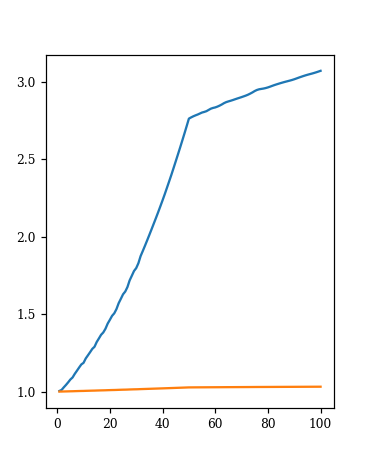

In [161]:
plt.plot(x, i111)
plt.plot(x, i220)
#plt.plot(*transform(x, i111))

<IPython.core.display.Javascript object>


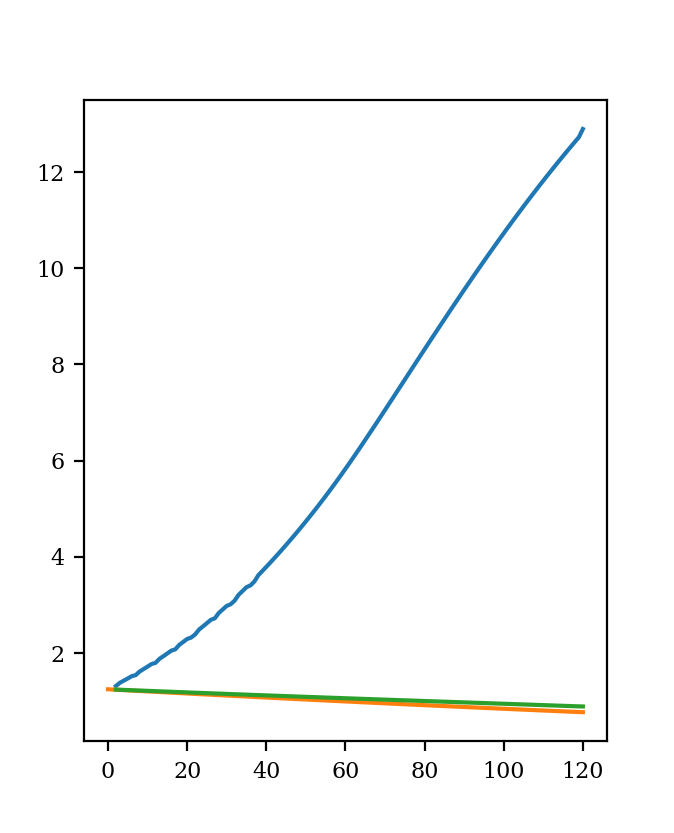

In [19]:
intensity_fractions = np.arange(0, 6, 6./121)
i111_abs, i200_abs, i220_abs = interp1d(intensity_fractions, i111 * i200, fill_value= 'extrapolate'), interp1d(intensity_fractions, i200, fill_value= 'extrapolate'), interp1d(intensity_fractions, i220 * i200, fill_value= 'extrapolate')
plt.plot(i111_abs(intensity_fractions))
plt.plot(i200_abs(intensity_fractions))
plt.plot(i220_abs(intensity_fractions))


hbarc = 1973.
E = 9000.
q= lambda theta: 2 * E/hbarc * np.sin(np.deg2rad(theta/2))
angle = lambda q: np.arcsin(hbarc * q / (2 * E))
peak_angles = np.array([33.5, 38.8, 55.9])
angles = np.arange(25, 65, 0.1)
sigma = 0.4
dw = np.exp(-(0.4)**2 * q(peak_angles)**2)
peakmodels = list(map(gauss, peak_angles, [sigma] * 3))
def pattern(ionization):
    from functools import reduce
    weights = dw * np.array([.028 * i111_abs(6 * ionization), 1.28 * i200_abs(6 * ionization), 1.64 * i220_abs(6 * ionization)])
    print(weights)
    return list(reduce(lambda x, y: x + y, np.array([w * pk(angles)
                                                               for w, pk in zip(weights, peakmodels)])))

### Same thing, using 1.5 eV (O electron affinity) instead of the band gap

Note:
* 1st EA: -1.42 kJ/mol
* 2nd EA: +844 kJ/mol

In [67]:
Oea = 1.
aff_ea_intensities = ev_to_flux((6./100) * x * Oea)
aff_ea_interp = extrap1d(interp1d(flux_to_ev(aff_ea_intensities), i111))

In [68]:
pulseavg_factor = 1.9

In [69]:
def shiftx(x, y, factor):
    new_y_interp = interp1d(x * factor, y)
    mask = np.logical_and(min(x * factor) < x, x < max(x * factor))
    newx = x[mask]
    return mask, new_y_interp(newx)

In [70]:
import pdb

In [71]:
def plot_and_shade_right(x, y, color, factor = 3., label = '',):
    i = np.argsort(x)
    x = x[i]
    y = y[i]
    mask, shifted = shiftx(x, y, factor)
    ax2.plot(x, y, color= color)
    fill_x = x[~mask]
    fill_y = np.repeat(min(shifted), len(fill_x))
    newy = np.concatenate((fill_y, shifted))
    
    ax2.fill_between(x, y, newy, alpha = 0.5, label = label, color = color)
    #ax2.fill_between(fill_x, fill_y, np.repeat(0., len(fill_x)), alpha = 0.5, label = label, color = color)

In [72]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 1, height_ratios=[1,1, 3])

In [24]:
i0_200_mean

array([ 1.        ,  0.84899707,  0.88030385,  0.85508749,  0.86823822,
        0.86725699,  0.91347047])

In [25]:
mean[2] * i0_200_mean

array([ 1.        ,  0.8152166 ,  0.84876751,  0.85459069,  0.82994436,
        0.85694666,  0.91233588])

In [26]:
mean[2]

array([ 1.        ,  0.96021133,  0.96417563,  0.99941901,  0.95589476,
        0.98811157,  0.99875793])

In [27]:
i0_200_mean

array([ 1.        ,  0.84899707,  0.88030385,  0.85508749,  0.86823822,
        0.86725699,  0.91347047])

<IPython.core.display.Javascript object>


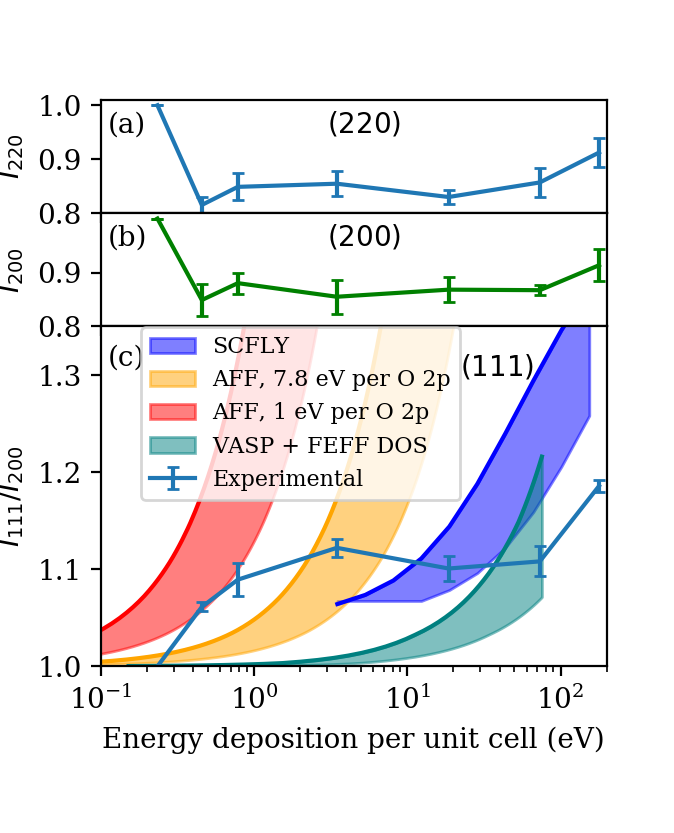

/Users/oliver/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [28]:
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 2
mpl.rcParams['font.size'] = 10
capsize = 2

fig = plt.figure()

#ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2,sharex=ax1)

ax0 = fig.add_subplot(gs[0])
ax0.text(3, .95, '$(220)$')
ax0.semilogx()
ax0.text(0.11, .95, '(a)')
ax0.set_ylabel('$I_{220}$')
ax0.set_xlim(0.1, 2e2)
ax0.set_ylim((.8, 1.01))
ax0.set_yticks([0.8, 0.9, 1.0])

plt.setp(ax0.get_xticklabels(), visible=False)


ax1 = fig.add_subplot(gs[1])
ax1.text(3, 0.95, '$(200)$')

ax2 = fig.add_subplot(gs[2])#,sharex=ax1)
ax2.text(22, 1.3, '$(111)$')

ax1.set_ylabel('$I_{200}$')

ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()


#ax1 = ax1.twiny()
ax1.errorbar(flux_to_ev(fluxes), i0_200_mean, yerr=i0_200_stderr,
             label = label, color = 'g', capsize = capsize)
#ax1.get_yaxis().get_ticklabels()[-1].set_visible(False)

ax1.set_xlim(0.1, 2e2)
ax1.set_ylim((.8, 1.01))
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(0.11, .95, '(b)')



x, y = np.arange(10), np.arange(10)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.15)

#for curve, err, label in zip(mean, stderr, labels):
ax0.errorbar(flux_to_ev(fluxes), mean[2] * i0_200_mean, yerr=stderr[2], label = 'Experimental',
             capsize = capsize)
ax1.set_yticks([.8, .9])
#ax1.get_yaxis().get_ticklabels()[0].set_visible(False)


ax2.errorbar(flux_to_ev(fluxes), mean[0], yerr=stderr[0], label = 'Experimental',
            capsize = capsize)


plot_and_shade_right(flux_to_ev(scfly_intensities), scfly_ratios, 'blue',
                     factor = 3., label = 'SCFLY')

plot_and_shade_right(flux_to_ev(np.arange(0, 3000, 1) * pulseavg_factor),
                     aff_bandgap_interp(flux_to_ev(np.arange(0, 3000, 1))),
         'orange', label = 'AFF, 7.8 eV per O 2p') 


plot_and_shade_right(flux_to_ev(np.arange(1, 750, 1) * pulseavg_factor),
                     aff_ea_interp(flux_to_ev(np.arange(1, 750, 1))), 'red', label = 'AFF, 1 eV per O 2p')


# already account for pulse averaging in MgO_VASP
plot_and_shade_right(flux_to_ev(vasp_intensities), vasp_ratios, 'teal', label = 'VASP + FEFF DOS')


ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

ax2.set_ylim((1., 1.35))

fig.subplots_adjust(hspace=0)

ax1.semilogx()
ax2.semilogx()

xscale = .0026

ax2.set_xlabel('Energy deposition per unit cell (eV)')
ax2.set_ylabel('$I_{111}/I_{200}$')
ax2.text(0.11, 1.31, '(c)')


ax2.set_xlim(0.1, 2e2)
handles, labelsrev = ax2.get_legend_handles_labels()

#handles = [h[0] for h in handles]
leg = ax2.legend(handles, labelsrev, loc='upper center', ncol = 1,
               bbox_to_anchor = (0.395, 1.03), prop = {'size' : 8})#, numpoints=1)



In [115]:
flux_to_ev(fluxes)

array([  0.05132298,   0.1000493 ,   0.17193391,   0.76151006,
         4.09087751,  16.11525922,  39.26742518])

In [34]:
from utils.utils import extrap1d

In [35]:
extrap1d

<function utils.utils.extrap1d>

<IPython.core.display.Javascript object>


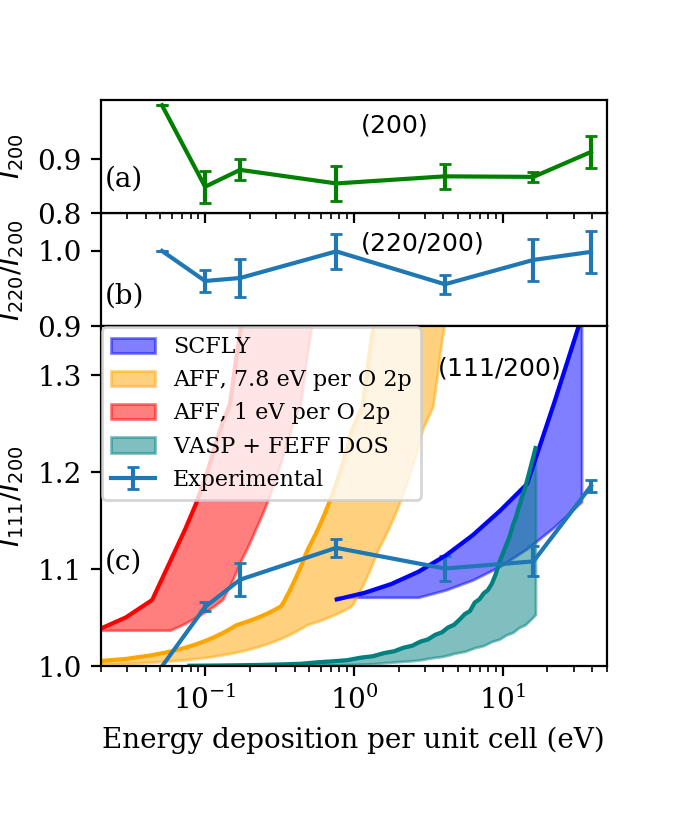

/Users/oliver/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [119]:
xmin, xmax = .02, 5e1
letterx = .021
lettery = .9

mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 2
mpl.rcParams['font.size'] = 10
capsize = 2

fig = plt.figure()

#ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2,sharex=ax1)

ax0 = fig.add_subplot(gs[1])
ax0.text(1.1, 1., '$(220/200)$', size = 9)
ax0.semilogx()
ax0.text(letterx, .93, '(b)')
ax0.set_ylabel('$I_{220}/I_{200}$')
ax0.set_xlim(xmin, xmax)
ax0.set_ylim((.9, 1.05))
ax0.set_yticks([0.9, 1.0])

plt.setp(ax0.get_xticklabels(), visible=False)


ax1 = fig.add_subplot(gs[0])
ax1.text(1.1, .95, '$(200)$', size = 9)

ax2 = fig.add_subplot(gs[2])#,sharex=ax1)
ax2.text(3.6, 1.3, '$(111/200)$', size = 9)

ax1.set_ylabel('$I_{200}$')

ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()


#ax1 = ax1.twiny()
ax1.errorbar(flux_to_ev(fluxes), i0_200_mean, yerr=i0_200_stderr,
             label = label, color = 'g', capsize = capsize)
#ax1.get_yaxis().get_ticklabels()[-1].set_visible(False)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim((.8, 1.01))
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(letterx, .85, '(a)')


x, y = np.arange(10), np.arange(10)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.15)

#for curve, err, label in zip(mean, stderr, labels):
ax0.errorbar(flux_to_ev(fluxes), mean[2], yerr=stderr[2], label = 'Experimental',
             capsize = capsize)
ax1.set_yticks([.8, .9])
#ax1.get_yaxis().get_ticklabels()[0].set_visible(False)


ax2.errorbar(flux_to_ev(fluxes), mean[0], yerr=stderr[0], label = 'Experimental',
            capsize = capsize)


plot_and_shade_right(flux_to_ev(scfly_intensities), scfly_ratios, 'blue',
                     factor = 3., label = 'SCFLY')

plot_and_shade_right(flux_to_ev(np.arange(0, 3000 * beamline_transmission, 1) * pulseavg_factor),
                     aff_bandgap_interp(flux_to_ev(np.arange(0, 3000 * beamline_transmission, 1))),
         'orange', label = 'AFF, 7.8 eV per O 2p') 


plot_and_shade_right(flux_to_ev(np.arange(1, 750 * beamline_transmission, 1) * pulseavg_factor),
                     aff_ea_interp(flux_to_ev(np.arange(1, 750 * beamline_transmission, 1))), 'red', label = 'AFF, 1 eV per O 2p')


# already account for pulse averaging in MgO_VASP
plot_and_shade_right(flux_to_ev(vasp_intensities), vasp_ratios, 'teal', label = 'VASP + FEFF DOS')


ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

ax2.set_ylim((1., 1.35))

fig.subplots_adjust(hspace=0)

ax1.semilogx()
ax2.semilogx()

xscale = .0026

ax2.set_xlabel('Energy deposition per unit cell (eV)')
ax2.set_ylabel('$I_{111}/I_{200}$')
ax2.text(letterx, 1.1, '(c)')


ax2.set_xlim(xmin, xmax)

handles, labelsrev = ax2.get_legend_handles_labels()

#handles = [h[0] for h in handles]
leg = ax2.legend(handles, labelsrev, loc='upper center', ncol = 1,
               bbox_to_anchor = (0.317, 1.03), prop = {'size' : 8})#, numpoints=1)



In [42]:
plt.plot(i220)
plt.show()

In [117]:
fig.savefig('experimental_vs_scfly_vasp_exciton_shaded.svg', dpi = 300, bbox_inches='tight')

In [118]:
fig.savefig('experimental_vs_scfly_vasp_exciton_shaded.png', dpi = 300, bbox_inches='tight')

In [186]:
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 1.3
mpl.rcParams['font.size'] = 9


#plt.tight_layout()

fig = plt.figure()

x, y = np.arange(10), np.arange(10)
ax2 = fig.add_subplot(1,1,1)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.15)

for curve, err, label in zip(mean, stderr, labels):
    ax2.errorbar(flux_to_ev(fluxes), curve, yerr=err, label = label)


plot_and_shade_right(flux_to_ev(scfly_intensities), scfly_ratios, 'blue',
                     factor = 3., label = 'SCFLY')

plot_and_shade_right(flux_to_ev(np.arange(15, 3000, 1) * pulseavg_factor),
                     aff_bandgap_interp(flux_to_ev(np.arange(15, 3000, 1))),
         'orange', label = 'AFF, 7.8 eV per O 2p')


plot_and_shade_right(flux_to_ev(np.arange(5, 750, 1) * pulseavg_factor),
                     aff_ea_interp(flux_to_ev(np.arange(5, 750, 1))), 'red', label = 'AFF, 1 eV per O 2p')


# already account for pulse averaging in MgO_VASP
plot_and_shade_right(flux_to_ev(vasp_intensities), vasp_ratios, 'teal', label = 'VASP + FEFF DOS')


ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

ax2.set_ylim((0.9, 1.35))

fig.subplots_adjust(hspace=0)

ax2.semilogx()

xscale = .0026

ax2.set_xlabel('Energy deposition per unit cell (eV)')
ax2.set_ylabel('Intensity (normalized to 200)')
ax2.set_xlim(0.1, 2e2)
handles, labelsrev = ax2.get_legend_handles_labels()

#handles = [h[0] for h in handles]
leg = ax2.legend(handles, labelsrev, loc='upper center', ncol = 2,
               bbox_to_anchor = (0.5, 1.02), prop = {'size' : 7})#, numpoints=1)


<IPython.core.display.Javascript object>

[ 154.14944072  101.19221588   66.43142478   43.61019462   28.62849897
   18.79393378   12.3376623     8.09913557    5.31694992    3.49034673]


ValueError: A value in x_new is below the interpolation range.

In [117]:
fig.savefig('experimental_vs_scfly_vasp_exciton_shaded.png', dpi = 300, bbox_inches='tight')

### Model prediction

### LTE model:

<IPython.core.display.Javascript object>


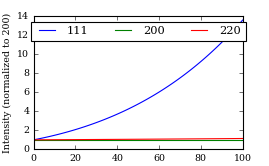

<IPython.core.display.Javascript object>


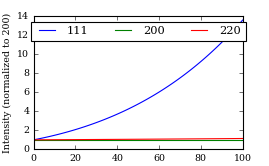

In [21]:
def plot_lte(dat, lcoords = (0.5, 1.)):
    x, i111, i200, i220 = dat[:4]
    labels  = ['111', '200', '220']

    mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

    # First illustrate basic pyplot interface, using defaults where possible.
    fig  = plt.figure()

    for curve, label in zip([i111, i200, i220], labels):
        plt.plot(x, curve, label = label)

    #plt.semilogx()
    #plt.ylim((0.9, 1.25))
    # remove the errorbars from the legend
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Ionization fraction (percent)')
    plt.ylabel('Intensity (normalized to 200)')
    
    handles = [h for h in handles]
    leg = ax.legend(handles, labels, loc='upper center', ncol = 3,
               bbox_to_anchor = lcoords)#, numpoints=1)
    return fig

dat =  np.genfromtxt('MgO_O2p.txt')
plot_lte(dat)


In [183]:
d = np.genfromtxt('MgO_simultaneous_r0.75.dat')

In [223]:
x = d[0][::2]
i111 = d[0][1::2]
i200 = d[1][1::2]
i220 = d[2][1::2]

<IPython.core.display.Javascript object>


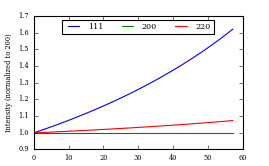

In [224]:
fig = plot_lte([x, i111, i200, i220], lcoords = (0.5, 1.))

In [220]:
fig.savefig('model2.png', dpi = 300, bbox_inches='tight')

In [201]:
plt.plot(i111)
plt.show()

In [180]:
!mv MgO_simultaneous_r0.75\ \(1\).dat MgO_simultaneous_r0.75.dat

In [182]:
pd.read_csv('MgO_simultaneous_r0.75.dat');

<IPython.core.display.Javascript object>


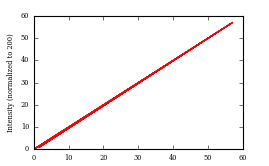

In [199]:
plot_lte('MgO_simultaneous_r0.75.dat')

In [ ]:
plot_lte('')

In [161]:
fig.savefig('prediction.png', dpi = 300, bbox_inches='tight')

In [3]:
import pandas as pd
import cufflinks
import plotly.plotly as py
py.sign_in('revilo222', 'qnGBeolE0CtdzjEajfql')